# Filter force plate data

> Alex Woodall <br>
> Auckland Bioengineering Institute <br>
> University of Auckland, New Zealand

To perform inverse dynamics in OpenSim, we need to preprocess the ground reaction forces (grf) from the force plate data. This will also convert the data from a csv data file to the required mot file.

This code will open up an existing force plate csv data file and preprocess the forces ready for inverse dynamics in OpenSim.

Start by importing the libraries needed to run the task.


In [13]:
import numpy as np
from numpy import matlib
import tkinter as tk
from tkinter import filedialog

import matplotlib.pyplot as plt
%matplotlib notebook

from scipy import signal
import csv

import sys

sys.path.insert(1, r'./../Functions') # add functions to path

from write_motion_file import write_motion_file

## Reading in the csv file

We first must choose the csv file to preprocess. Select the appropriate \_grf.mot file from the directory.

In [2]:
# read in some data from a csv file
root = tk.Tk()
root.withdraw()

# Get the file name from user input
file_path = filedialog.askopenfilename(initialdir = "r",title = "Select file",filetypes = (("csv files","*.csv"),("all files","*.*")))

grf_data = []

# Open the csv file
with open(file_path) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')

    for row in readCSV:
        grf_data.append(row)

# Close the csv file
csvfile.close()

# First line is the header, so ignore that.
grf_data = grf_data[1:]

# Convert to array of floats
grf_data = np.array(grf_data)

# Convert any empty strings to "0"
for i in range(np.shape(grf_data)[0]):
    for j in range(np.shape(grf_data)[1]):
        if grf_data[i,j] == "": # If it is empty, make 0
            grf_data[i,j] = "0"

# Change strings to floats
grf_data = grf_data.astype(np.float)

## Select the data

Once we have opened the csv file, we can now select the data which we want to preprocess. It is wise to open the csv file prior to running to ensure that the correct columns for your file are selected.

In [4]:
# Get data from the csv file data
time = grf_data[:,0] # time

# Force plate 1
force_plate1_forces = grf_data[:,1:4]
force_plate1_COP = grf_data[:,4:7] / 1000
force_plate1_Tz = grf_data[:,7]

# Force plate 2
force_plate2_forces = grf_data[:,8:11]
force_plate2_COP = grf_data[:,11:14] / 1000
force_plate2_Tz = grf_data[:,14]

# Force plate 3
force_plate3_forces = grf_data[:,15:18]
force_plate3_COP = grf_data[:,18:21] / 1000
force_plate3_Tz = grf_data[:,21]

## Filtering the data

We will use a low pass butterworth filter with a cut-off frequency of 15 Hz for this example. It would be wise to choose a cut-off frequency which is the same as what you filtered the kinematic data for dynamic consistancy.

We will be filtering just the data from force plate 2 in this example. Look at the file in Mokka to see what this force plate corresponds to.

<IPython.core.display.Javascript object>


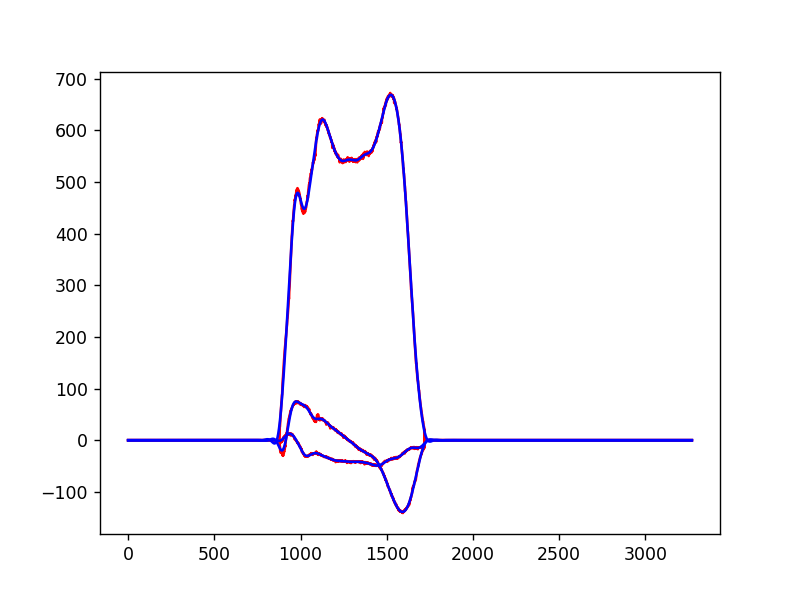

In [20]:
# Cut-off frequency for low pass Butterworth filter
cut_off_frequency = 15
analog_rate = 1200

# Filter the forces - do this just for force plate 2 as an example.
Wn = cut_off_frequency/(analog_rate/2)

# Describe filter characteristics using 4th order Butterworth filter
b, a = signal.butter(4, Wn)

force_plate2_forces_filt = signal.filtfilt(b, a, force_plate2_forces,axis=0)
force_plate2_Tz_filt = signal.filtfilt(b, a, force_plate2_Tz,axis=0)

# Plot the filtered and unfiltered forces as a visual check
fig, ax = plt.subplots(1, 1)
ax.plot(force_plate2_forces,'r')
ax.plot(force_plate2_forces_filt,'b')

plt.show()

<IPython.core.display.Javascript object>


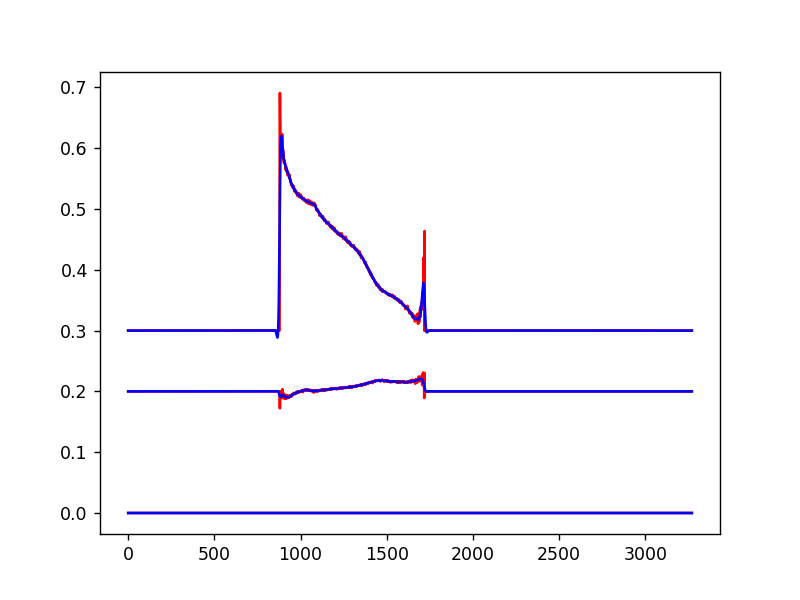

In [23]:
# Filter the CoP - note that the CoP should really be re-calculated after filtering the forces
# This is a hack, since we are not going to recalculate the CoP
cut_off_frequency = 50
analog_rate = 1200

Wn = cut_off_frequency/(analog_rate/2)

b, a = signal.butter(2, Wn)
force_plate2_COP_filt = signal.filtfilt(b, a, force_plate2_COP,axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(force_plate2_COP,'r')
ax.plot(force_plate2_COP_filt,'b')

plt.show()

## Post-processing after filtering

### Residuals
Filtering often will have residual effects which will effect our analysis. Therefore, when the vertical forces drop below a threshold (20 N), we will set the force and centre of pressure values to be 0.

In [24]:
# Find when the vertical forces drop below threshold, and then make all of the forces and CoP values 0.0 at these points.
force_threshold = 20 # Set this to 20 N

# Find the indices where the vertical force is below our threshold
force_zero = np.where(force_plate2_forces[:,2] < force_threshold)

# Set these values to 0
force_plate2_forces_filt[force_zero,:] = 0.0
force_plate2_COP_filt[force_zero,:] = 0.0
force_plate2_Tz_filt[force_zero] = 0.0

### Torque array

We need to make sure that the torque data are in a 3xn array. This will make it the same shape as the vertical force and centre of pressure arrays.

It is worth noting that the x and y torques are 0.

In [9]:
# Create a 3xn array of zeros
force_plate2_torques = np.zeros((len(force_plate2_Tz_filt), 3))

# Make the z component equal to the filtered Tz
force_plate2_torques[:,2] = force_plate2_Tz_filt

### Rotate data to fit with OpenSim

We want to rotate the force plate data 90° about X so that Y is the vertical axis.

To do this, first, we want the force data to be in one large array.

In [26]:
# Merge the 3 data arrays into one array
force_data = np.concatenate((force_plate2_forces_filt, force_plate2_COP_filt, force_plate2_torques),axis=1)
nt, nc = np.shape(force_data)

# Create rotation matrix
rot = np.array([(1, 0, 0), (0, 0, 1), (0, -1, 0)])

# Check that the number of columns is divisible by 3
if nc % 3 != 0:
    print("Error: force columns must have 3 components each")

# Rotate the marker data
rotated_force_data = np.zeros(np.shape(force_data))

for i in range(int(nc/3)):
    rotated_force_data[:,(3*(i+1)-3):3*(i+1)] = np.matmul(rot, force_data[:, (3*(i+1)-3):3*(i+1)].T).T

## Writing to a motion file

Now that the preprocessing of the force plate data is complete, we can output the data to a motion file. We will be outputting the time data as well as the force plate data to a motion file.

In [11]:
# Concatenate time with rotated forces and torques into one array
grf_complete = np.concatenate((time[:,np.newaxis], rotated_force_data),axis=1)

In [12]:
# Now output data to a motion file
write_motion_file(grf_complete, file_path)

C:/Users/alexw/Dropbox/ABI/BIOMENG 771 Files/BIOMENG_771/KineticsLabData/jw_ngait_og1_grf.mot
